# Team 24 Group Project 

Date: April 15th 2021

Authors: Kian Da Costa, Jack He, Dani Fookes, Ethan Tse


# Introduction:

For students, balancing life and school can be challenging, and achieving a balance between leisure and studying is often critical to a good academic standing. 

The dataset we will be using for this analysis was collected by Paulo Cortez from the University of Minho, GuimarÃ£es, Portugal (1). This dataset details the performance of students aged 15-22 from two Portugeuse secondary schools. Each row represents an observation of a single student, with the grades they received from each period (G1, G2, G3) along with various details of their life, such as how much free time they have, whether they are in a romantic relationship etc.

Here, we propose using a K nearest neighbors Classification (KNN)-model to explore the relationship between time spent on several common distractions and grades received in school.

Our predictors of choice are the following: 
+ Workday Alcohol Consumption (Dalc)
+ Weekend Alcohol Consumption (Walc)
+ Going out with Friends (goout)

We decided to investigate alcohol consmption as a predictor of academic success in Portugal as a recent study by Dong et al. found that in both boys and girls, increased frequency of alcohol consumption and severe intoxication led to decreased academic performance in Korea (2). While this data does not record severe intoxications, we believe it will still be interesting to see if alcohol consumption can be used predict academic performance. 

Friendship dynamics can play a pivotal role in an individual's academic success. They can be both supportive and encouraging and toxic and discouraging (3). Furthermore, academic achievements may also impact friendship dynamics by linking high-achieving students with other high-achieving students (3). With these possible impacts on academic performance, we are interested in seeing if the frequency of going out with friends by these portugese students can be used as a predictor of academic performance. 

If our models are accurate, this may be useful for teachers and educators to use to predict their students' final grades.

# Load Relevant Libraries

In [37]:
library(tidyverse)
library(tidymodels)
library(cowplot)
library(RColorBrewer)
library(repr)
set.seed(1000)

# Data Collection

First we read the data into a workable form.

Data from: https://archive.ics.uci.edu/ml/machine-learning-databases/00320/ and https://archive.ics.uci.edu/ml/datasets/Student+Performance

In [38]:
#Idea from: https://stackoverflow.com/questions/3053833/using-r-to-download-zipped-data-file-extract-and-import-data

#make a temporary file 
tempfile <- tempfile()

#download file into temp 
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", 
              tempfile) 

#extract relevant files 
student_mat <- read.table(unz(tempfile, "student-mat.csv"), 
                          header = TRUE, 
                          sep = ";")
student_por <- read.table(unz(tempfile, "student-por.csv"), 
                          header = TRUE, 
                          sep = ";")
unlink(tempfile)

#read files to see
head(student_mat, 5)
head(student_por, 5)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
2,GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
3,GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
4,GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
5,GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,4,0,11,11
2,GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,2,9,11,11
3,GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,6,12,13,12
4,GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,0,14,14,14
5,GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,0,11,13,13


Table 1. The first 5 rows of the 2 datasets we will be using: Students in a math class and students in a portugese class, respectively.

## Tidying the data
Here, we merge the two datasets to include grades for both Math and Portugese

Since we would like to attempt a K-nearest neighbours classification and the G3 grade column is a numerical variable, we instead need to represent the G3 column as some classes. To do this we will add a new column (G3_class) that represents each range of G3 grade as a certain letter grade.

We use the portugese grading system found at: https://www.scholaro.com/pro/Countries/Portugal/Grading-System. This website shows the portugese grades on a 1-20 scale to letter grades on the American Grading System

In [59]:
#Merge the datasets
total_set <- rbind(student_mat, student_por) 

#filter for desired columns
filtered_set <- total_set %>% 
                select(goout, Dalc, Walc, G3)

#Here, we specify a new column that displays the numerical grade as a certain letter grade
data_with_lg_class <- filtered_set %>% 
    mutate(G3_class = case_when((G3 >= 0 & G3 <= 6.99) ~ "F",
                                (G3 >= 7 & G3 <= 9.99) ~"D",
                                (G3 >= 10 & G3 <= 13.99) ~ "C",
                                (G3 >= 14 & G3 <= 15.99) ~ "B", 
                                (G3 >= 16 & G3 <= 17.99) ~ "A",
                                (G3 >= 18 & G3 <= 20 ~ "A+")),
          G3_class = as.factor(G3_class)) 

head(data_with_lg_class, 10)
#Check unique values to make sure letter grades were assigned
unique(data_with_lg_class$G3_class)

,goout,Dalc,Walc,G3,G3_class
,<int>,<int>,<int>,<int>,<fct>
1,4,1,1,6,F
2,3,1,1,6,F
3,2,2,3,10,C
4,2,1,1,15,B
5,2,1,2,10,C
6,2,1,2,15,B
7,4,1,1,11,C
8,4,1,1,6,F
9,2,1,1,19,A+


[1] F  C  B  A+ D  A 
Levels: A A+ B C D F

Table 2. Relevant data set with added column to represent G3 numerical grades as letter grade classes

## Splitting data to training and test sets

We are splitting our data with a proportion of 0.75 because we want to maximize the amount of training data we have. Using more training data will allow for a more accurately trained classifier, but we left 0.25 as a testing set to ensure there is sufficient data that can hopefully capture the distribuiton of the original dataset. 

In [66]:
#Set seed to ensure reproducibility 
set.seed(1000)

#split our dataset into a training and testing set.
data_split <- initial_split(data_with_lg_class, prop = 0.75, strata = G3_class)  #where G3 = final grade
data_train_with_lg_class <- training(data_split)   
data_test_with_lg_class <- testing(data_split)
head(data_train_with_lg_class, 4)

,goout,Dalc,Walc,G3,G3_class
,<int>,<int>,<int>,<int>,<fct>
4,2,1,1,15,B
6,2,1,2,15,B
7,4,1,1,11,C
8,4,1,1,6,F


Table 3. First 4 observations of the training dataset.

# Exploratory Data Analysis: 

### Calculating the Average Value of the three predictor variables 


In [41]:
#Find the mean of our predictor variables goout, Dalc, Walc
predictor_means <- data_train_with_lg_class %>%
                   select(goout, Dalc, Walc) %>%
                   map_df(mean)
predictor_means

goout,Dalc,Walc
<dbl>,<dbl>,<dbl>
3.173248,1.48535,2.28535


Table 4. Mean values of our predictors. 

We can see that on average more people go out with their friends versus drinking alcohol on the weekdays or weekends. It will be interesting to see if this variable has a greater effect on students' grades versus alcohol consumption.

## Visualization: 

Here, we plot how often students with good grades (G3>=16 or G3_class = A or A+) go out or consume alcohol on workdays or weekends. 

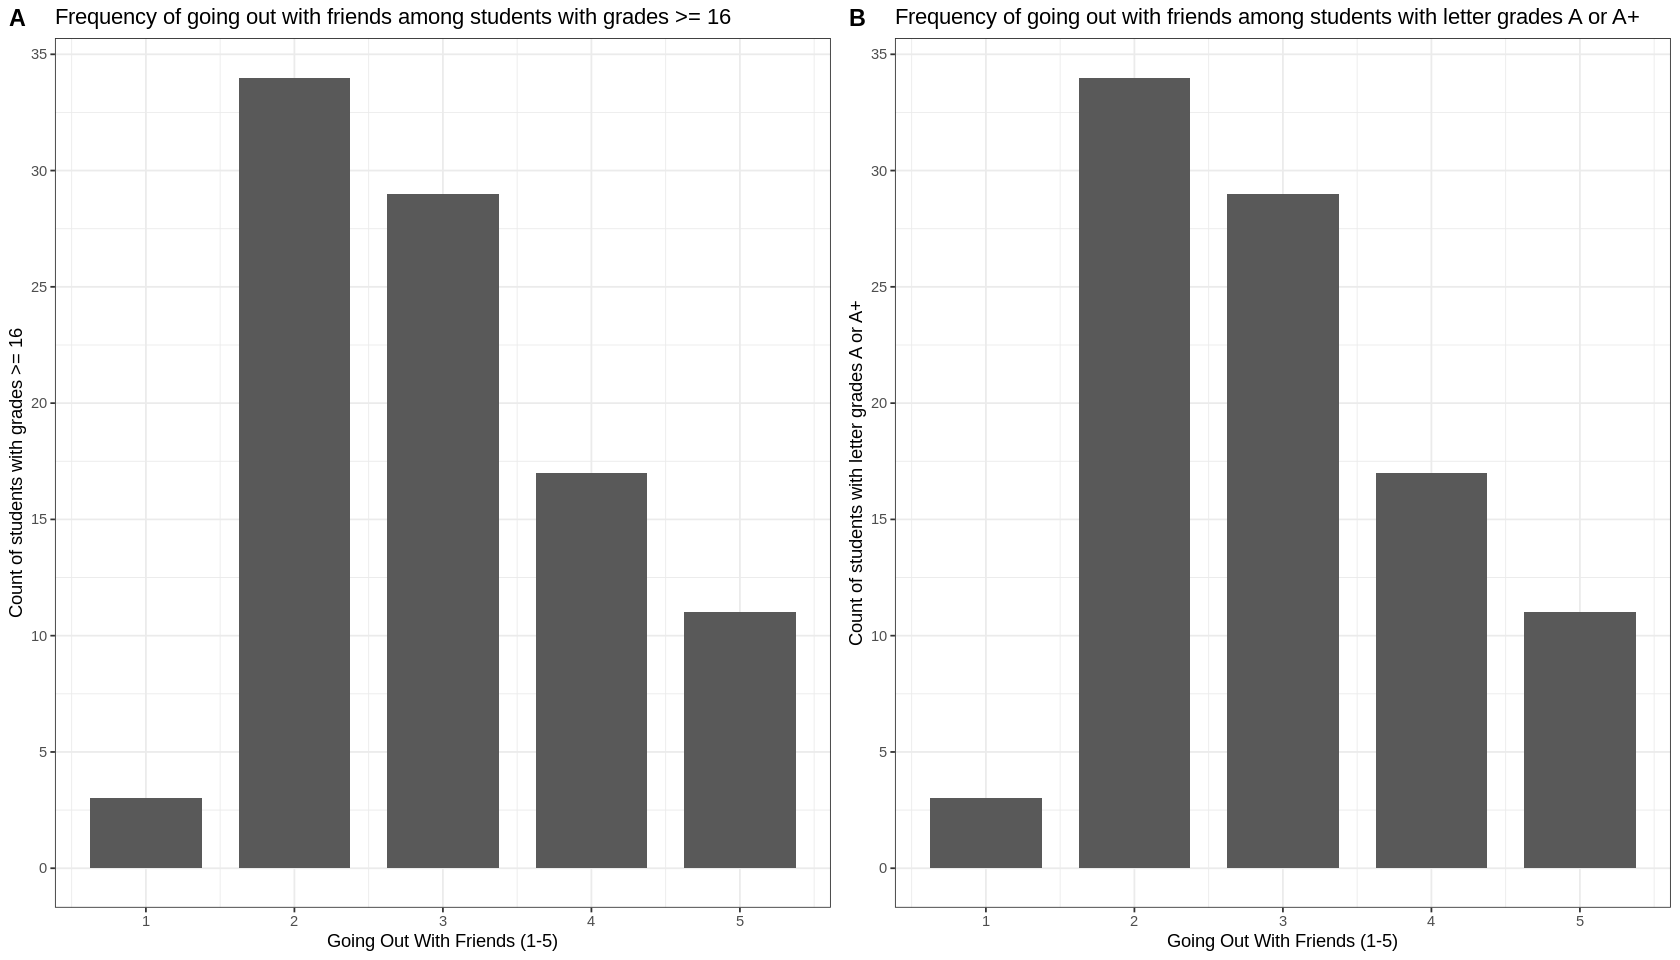

In [55]:
#plots that display the count of how many people got good grades (G3 >= 16) for each predictor variable

options(repr.plot.width = 14, repr.plot.height = 8)

goout_viz <- data_train_with_lg_class %>%
    filter(G3 >= 16) %>%
    ggplot(aes(x = goout)) +
    geom_bar(width = 0.75) +
    labs(x = "Going Out With Friends (1-5)", 
        y = "Count of students with grades >= 16") + 
    ggtitle("Frequency of going out with friends among students with grades >= 16") + 
    scale_y_continuous(n.breaks = 10) +
    theme_bw()

goout_viz_lg <- data_train_with_lg_class %>%
    filter(G3_class %in% c("A", "A+")) %>%
    ggplot(aes(x = goout)) +
    geom_bar(width = 0.75) +
    labs(x = "Going Out With Friends (1-5)", 
        y = "Count of students with letter grades A or A+") + 
    ggtitle("Frequency of going out with friends among students with letter grades A or A+") + 
    scale_y_continuous(n.breaks = 10) +
    theme_bw()


plot_grid(goout_viz, 
          goout_viz_lg, 
          labels = c("A", "B"), 
          ncol = 2
         )


Figure 1. Count of students achieving high grades (G3 >= 16 or G3_class = A/A+) at varying levels of going out with friends. 

These plots should be identical, and show that adding a new classification label (G3_class) can still capture the trend of alcohol consumption. These plots show that the trend between going out with friends at students achieving high grades is not very clear. 

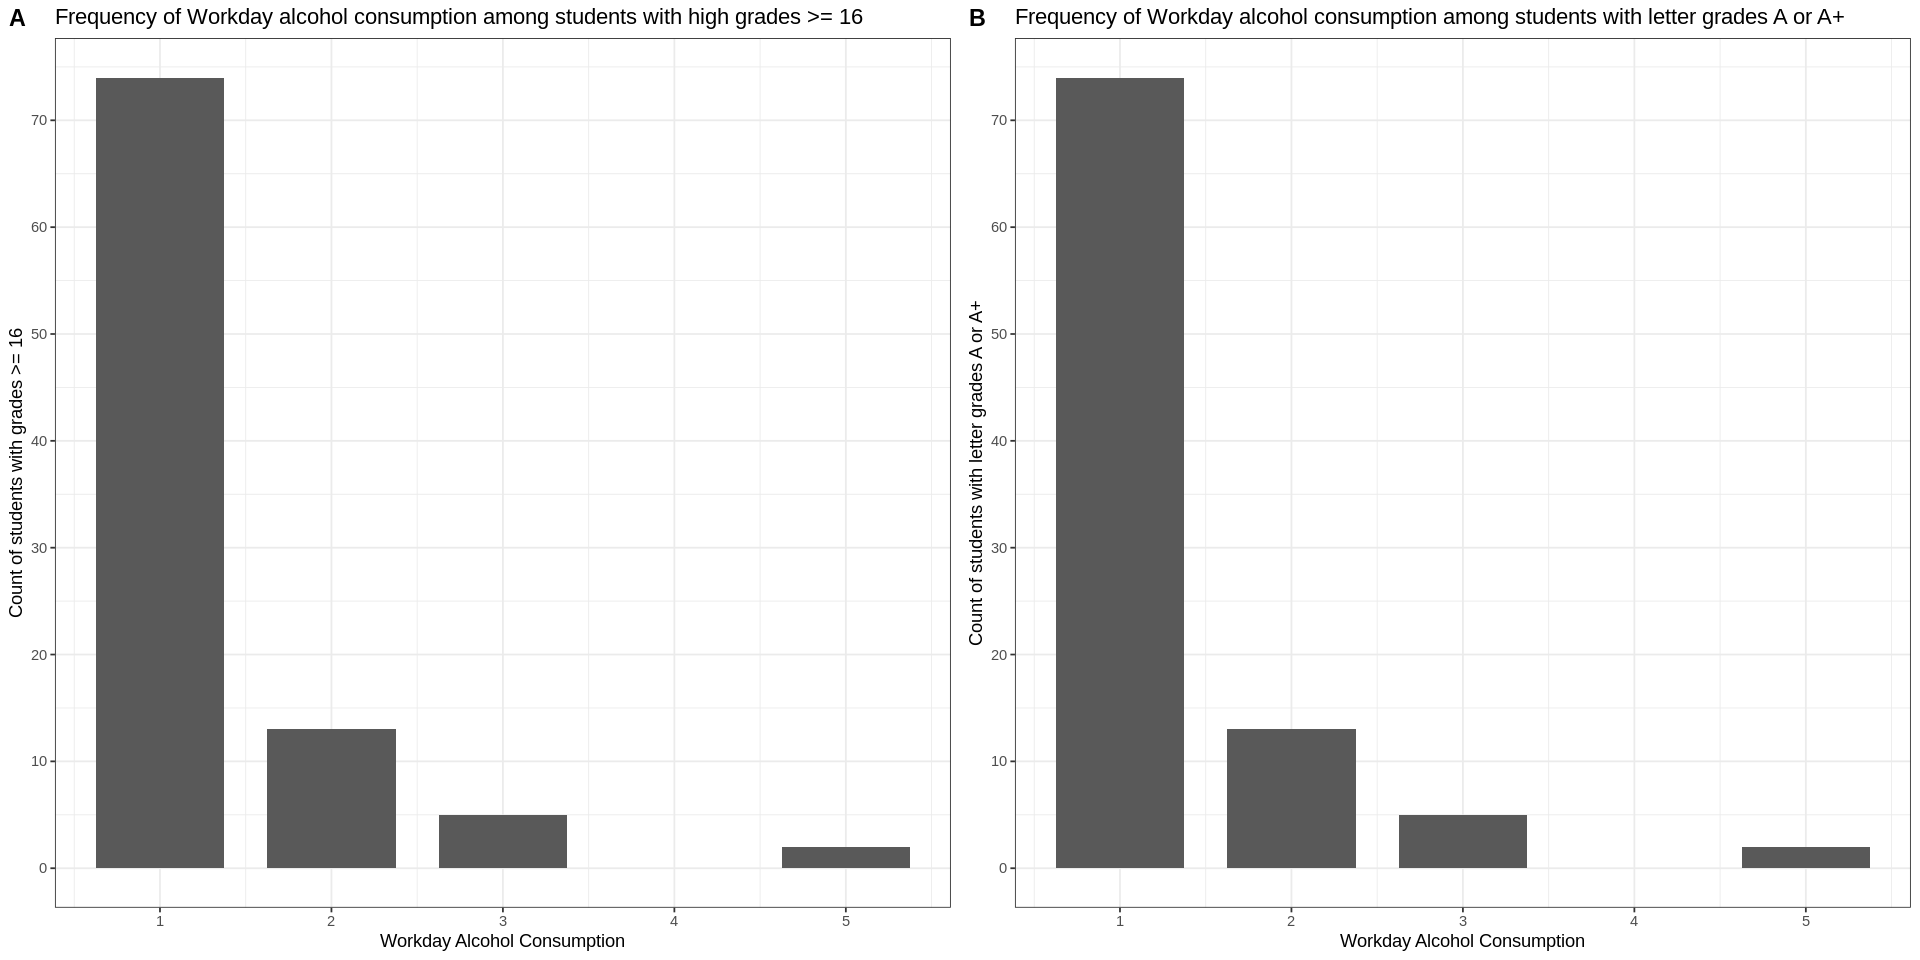

In [43]:
#visualize Workday Alcohol Consumption
options(repr.plot.width = 16, repr.plot.height = 8)

dalc_viz <- data_train_with_lg_class %>%
    filter(G3 >= 16) %>%
    ggplot(aes(x = Dalc)) +
    geom_bar(width = 0.75) +
    labs(x = "Workday Alcohol Consumption", 
        y = "Count of students with grades >= 16") + 
    ggtitle("Frequency of Workday alcohol consumption among students with high grades >= 16") + 
    scale_y_continuous(n.breaks = 10) +
    theme_bw()

dalc_viz_lg <- data_train_with_lg_class %>%
    filter(G3_class %in% c("A", "A+")) %>%
    ggplot(aes(x = Dalc)) +
    geom_bar(width = 0.75) +
    labs(x = "Workday Alcohol Consumption", 
        y = "Count of students with letter grades A or A+") + 
    ggtitle("Frequency of Workday alcohol consumption among students with letter grades A or A+") + 
    scale_y_continuous(n.breaks = 10) +
    theme_bw()

plot_grid(dalc_viz, 
          dalc_viz_lg, 
          labels = c("A", "B"), 
          ncol = 2)

Figure 2. Count of students achieving high grades (G3 >= 16 or G3_class = A/A+) at varying levels of alcohol consumption in the workday 

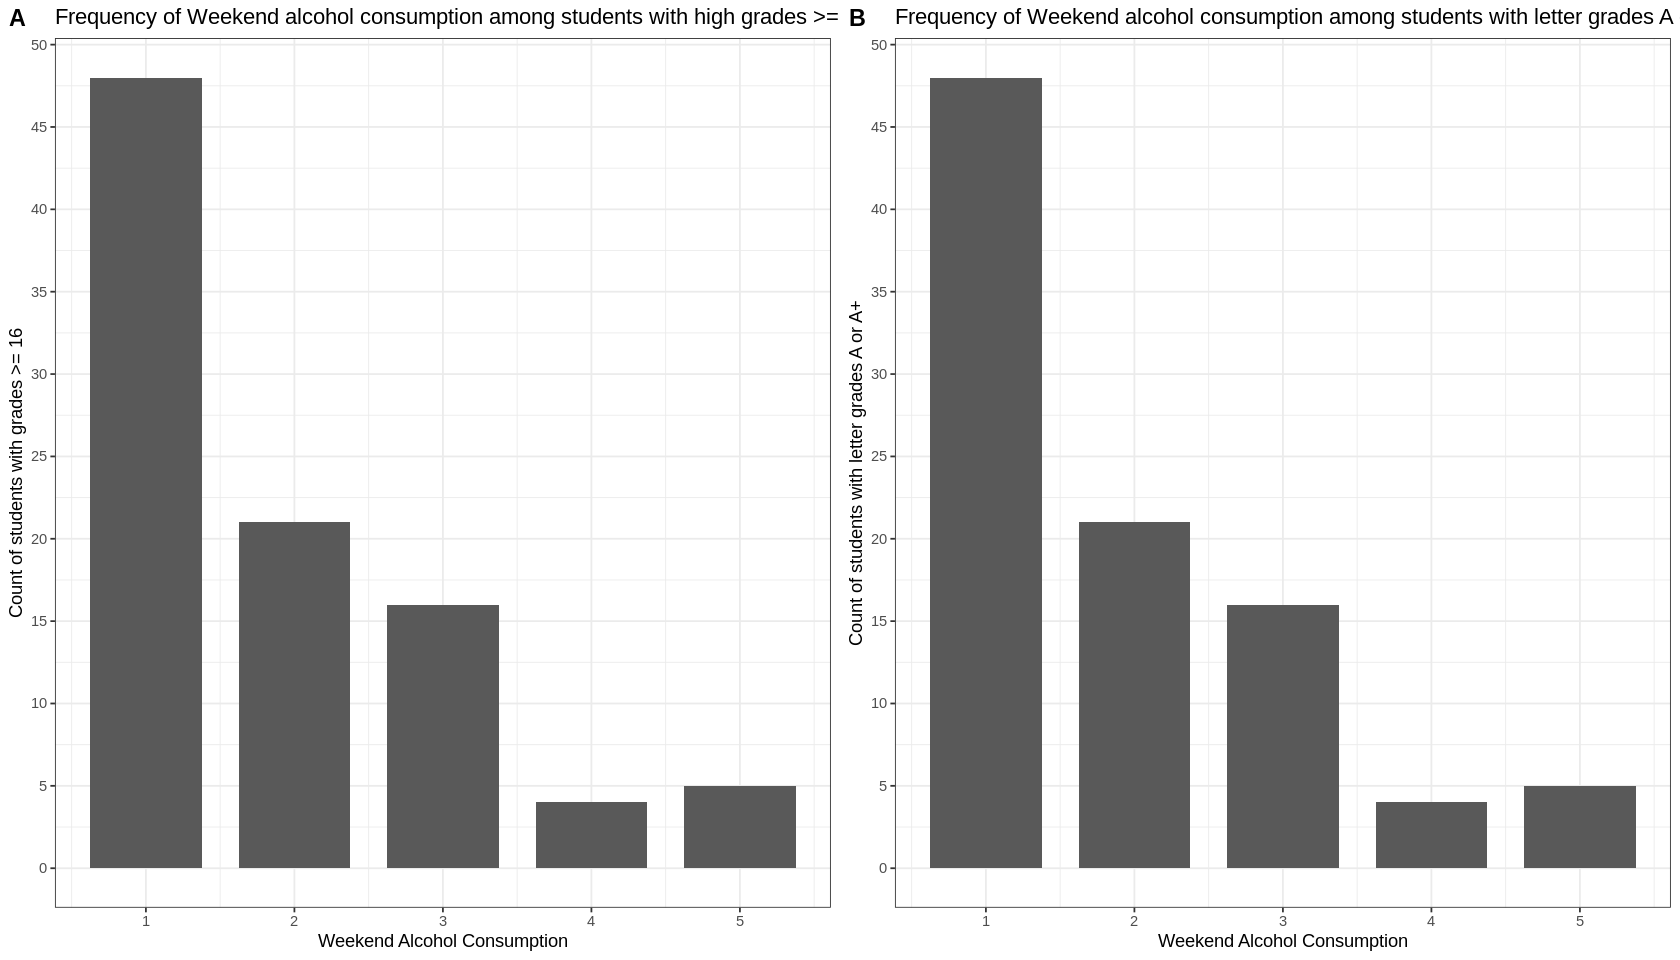

In [44]:
#Visualize weekend alcohol consumption 
options(repr.plot.width = 14, repr.plot.height = 8)

walc_viz <- data_train_with_lg_class %>%
    filter(G3 >= 16) %>%
    ggplot(aes(x = Walc)) +
    geom_bar(width = 0.75) +
    labs(x = "Weekend Alcohol Consumption", 
        y = "Count of students with grades >= 16") + 
    ggtitle("Frequency of Weekend alcohol consumption among students with high grades >= 16") + 
    scale_y_continuous(n.breaks = 10) +
    theme_bw()

walc_viz_lg <- data_train_with_lg_class %>%
    filter(G3_class %in% c("A", "A+")) %>%
    ggplot(aes(x = Walc)) +
    geom_bar(width = 0.75) +
    labs(x = "Weekend Alcohol Consumption", 
        y = "Count of students with letter grades A or A+") + 
    ggtitle("Frequency of Weekend alcohol consumption among students with letter grades A or A+") + 
    scale_y_continuous(n.breaks = 10) +
    theme_bw()

plot_grid(walc_viz, 
          walc_viz_lg, 
          labels = c("A", "B"), 
          ncol = 2)

Figure 3. Count of students achieving high grades (G3 >= 16 or G3_class = A/A+) at varying levels of alcohol consumption on the weekend

Overall, these plots show that there is a clear trend with alcohol consumption - students who drink more alcohol tend to not get good grades. However, the trend is not as clear with the "going out with friends" variable. 

It will interesting to explore how these variables perform as predictors for classification and regression models.

# Predictive Data Analysis

## Predictive Analysis 1) K Nearest Neighbours Classification

In the proceding section we begin to create our K-nn classification algorithm in order to discover if the various distractions from school can accurately predict students' academic performance.

## Data Preprocessing 

To ensure our data is in a usable form for KNN Classification, we first need to check if the number of observations for each class is similar. If we do not check this, and it turned out that some classes were overrepresented, the model will not be properly trained and would be skewed in favour of the overrepressented classes (letter grades in this case). 

In [63]:
#Add summary to check if class imbalance is present. 
class_imbalance_summary <- data_train_with_lg_class %>% 
    select(G3_class) %>% 
    group_by(G3_class) %>% 
    summarize(n = n(),
              percentage = n() / nrow(data_train_with_lg_class) * 100)

class_imbalance_summary

`summarise()` ungrouping output (override with `.groups` argument)



G3_class,n,percentage
<fct>,<int>,<dbl>
A,71,9.056122
A+,23,2.933673
B,125,15.943878
C,390,49.744898
D,113,14.413265
F,62,7.908163


Table 5. Distribution of classes in the training set

Here, we can see from the summary table the number of observations for each class. Since there is a class imbalance, we would need to __balance__ the labels. We can do this using __step_upsample__ in the recipe. 

Next, we can check the range of our predictor values. If they are not on scales that are meaningfully different, we will need to scale them. 

In [47]:
#Check scales of the predictor variables 
predictor_scales <- G3_class_data_train %>%  
    select(-G3, -G3_class) %>% 
    map_df(range) #using map_df to iterate over columns. 

predictor_scales

goout,Dalc,Walc
<int>,<int>,<int>
1,1,1
5,5,5


Table 5. Range of predictor variables

From this analysis, we can see that goout, Dalc, Walc are on on the same scale, they range from values 1 to 5. Thus, scaling is not explicitly needed here. For completeness of data preprocessing, however, we will scale and center. 

In [64]:
set.seed(1000)

#lg = letter grade


#Here, we create a recipe to be used in the workflow. We use the upsampled dataframe.
lg_classifier_recipe <- recipe(G3_class ~ goout + Walc + Dalc, 
                              data = data_train_with_lg_class) %>% 
    step_upsample(G3_class, over_ratio = 1) %>% 
    step_scale(all_predictors()) %>%  
    step_center(all_predictors()) 

#Further split data for CROSS-VALIDATION to select a suitable K
#data_train_new_classifier has 784 observations. This would be a suitable size for v = 10 for 10 fold cross-validation
nrow(data_train_with_lg_class)
#We do cross-validation on the original training set to avoid breaking the golden rule. if we cross-validate on an psampled dataset, 
#the validation sets in the cross validation set would be upsampled 
lg_data_cv <- data_train_with_lg_class %>% 
    vfold_cv(v = 10, 
             strata = G3_class)

#Create model specification 
lg_classifier_knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", 
                                          neighbors = tune()) %>%  
    set_engine("kknn") %>% 
    set_mode("classification") 

#We use seq 1:40 because testing more numbers leads to R being very, very slow. 
gridvals <- tibble(neighbors = seq(1:40))

#Create workflow for cross validation 
cv_workflow <- workflow() %>% 
    add_recipe(lg_classifier_recipe) %>%  
    add_model(lg_classifier_knn_spec_tune) %>%  
    tune_grid(resamples = lg_data_cv, 
              grid = gridvals)

cv_metrics <- cv_workflow %>%  
    collect_metrics() %>% 
    filter(.metric == "accuracy")

head(cv_metrics)
tail(cv_metrics)

[1] 784

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.1440491,10,0.009593555,Model01
2,accuracy,multiclass,0.1581039,10,0.008518448,Model02
3,accuracy,multiclass,0.1403653,10,0.010125252,Model03
4,accuracy,multiclass,0.1453803,10,0.012407500,Model04
5,accuracy,multiclass,0.1377359,10,0.010771813,Model05
6,accuracy,multiclass,0.1351384,10,0.010275199,Model06


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
35,accuracy,multiclass,0.1438373,10,0.01348809,Model35
36,accuracy,multiclass,0.1387245,10,0.01331255,Model36
37,accuracy,multiclass,0.1413052,10,0.01204678,Model37
38,accuracy,multiclass,0.1400881,10,0.01131121,Model38
39,accuracy,multiclass,0.1375236,10,0.01173095,Model39
40,accuracy,multiclass,0.1401539,10,0.01231897,Model40


Table 6. Accuracy metrics for various K values from cross-validation 

As can be seen, the accuracy estimates are very low. This may indicate that our predictors may not be the most suitable for our classifier. 

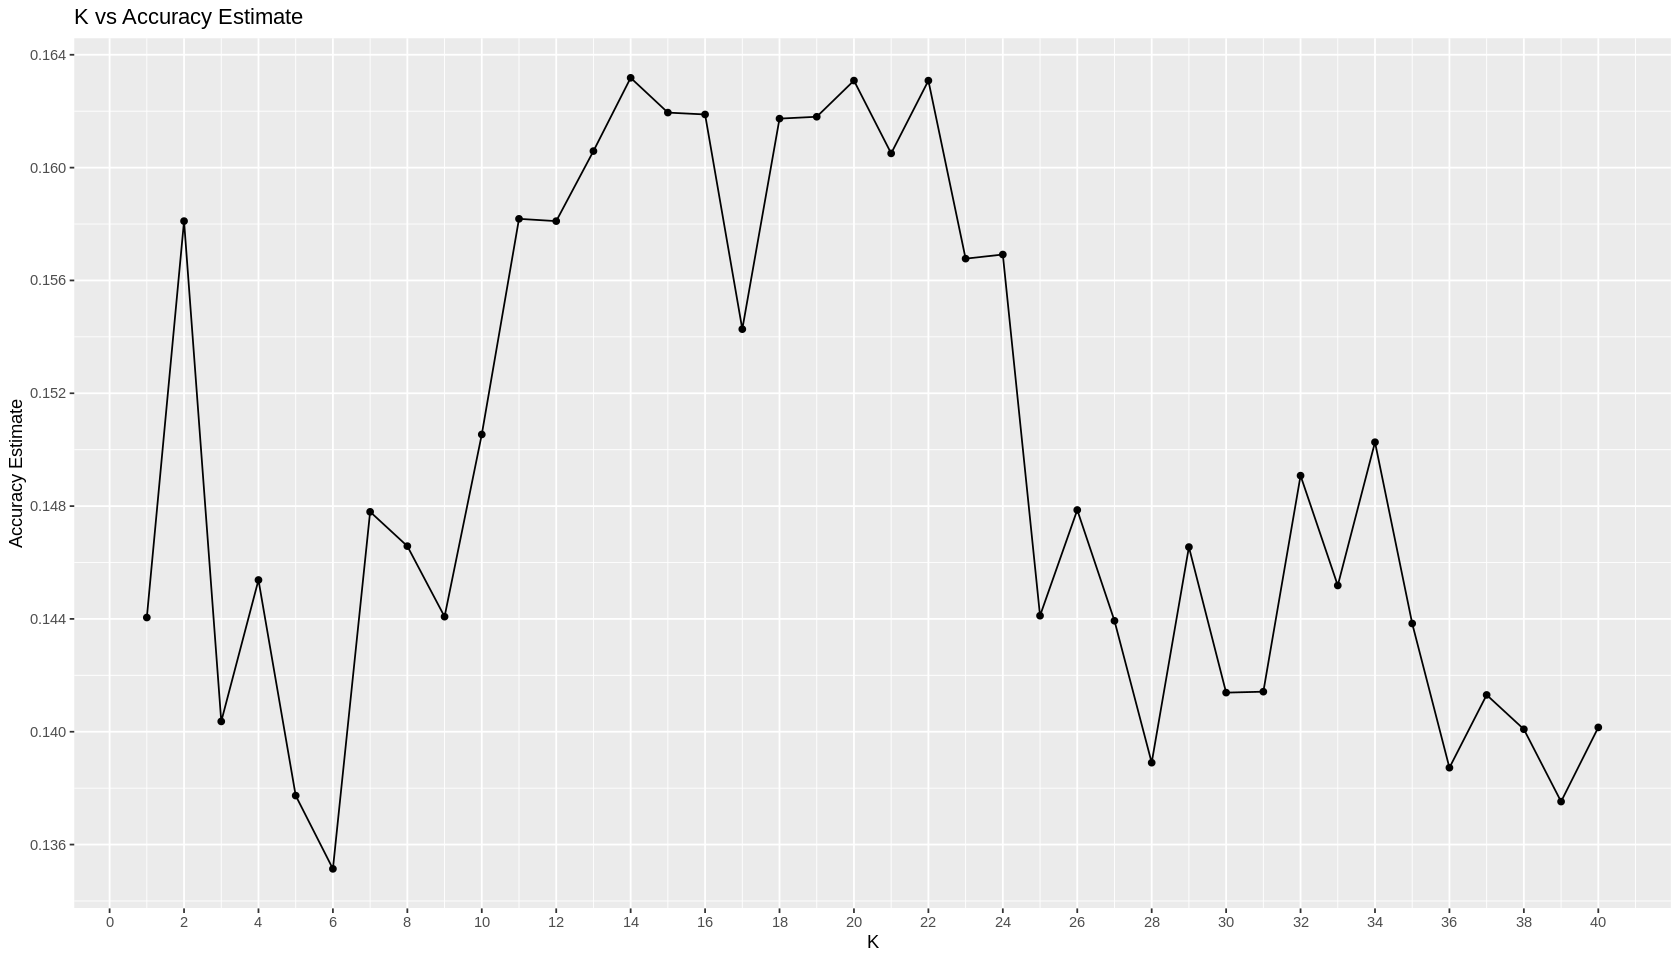

In [65]:
#Visualize the K
k_plot <- cv_metrics %>% 
    select(neighbors, mean) %>% 
    ggplot(aes(x = neighbors, 
              y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "K", 
         y = "Accuracy Estimate") + 
    scale_x_continuous(n.breaks = 20) + 
    scale_y_continuous(n.breaks = 10) +
    ggtitle("K vs Accuracy Estimate")

k_plot

Figure 4. Plotting K versus Accuracy shows that the optimal K value would be 14. However, it is important to note that the accuarcy estimate is very low (~0.163), which indicates that our predictors may not be very accurate. 

In [67]:
#Complete and create a KNN-Classifier 

#Specify a new KNN Classification Model, this time with the selected K value = 
lg_classifier_knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", 
                                                neighbors = 14) %>% 
    set_engine("kknn") %>% 
    set_mode("classification") 

#Create a fit
#we can reuse the recipe from the cross-validation 
lg_classifier_knn_fit <- workflow() %>% 
    add_recipe(lg_classifier_recipe) %>%  
    add_model(lg_classifier_knn_spec_tuned) %>% 
    fit(data = data_train_with_lg_class)

#using the fit, make predictions 
lg_predictions <- lg_classifier_knn_fit %>% 
    predict(data_test_with_lg_class) %>% 
    bind_cols(data_test_with_lg_class)

head(lg_predictions)

lg_prediction_metrics <- lg_predictions %>% 
    metrics(truth = G3_class, 
           estimate = .pred_class) 

#extract numerical value of accuracy
lg_predictor_accuracy <- lg_prediction_metrics %>% 
    filter(.metric == "accuracy") %>% 
    select(.estimate) %>% 
    pull()

lg_predictor_accuracy

.pred_class,goout,Dalc,Walc,G3,G3_class
<fct>,<int>,<int>,<int>,<int>,<fct>
A,4,1,1,6,F
A,3,1,1,6,F
A,2,2,3,10,C
A,2,1,2,10,C
A,1,1,1,15,B
B,3,1,3,14,B


[1] 0.1384615

Table 7. Showcasing sample results of our predicted class (.pred_class), vs the actual class (G3_class)

Here, we can see that the accuracy of our predictor, based on the predictors: goout, walc, and dalc, is quite poor, sitting at ~13% accurate. In the real world, this predictor would not be very useful as a way of predicting students' final grades based on their score of how many distractions they have. 

To see if we can come up with an accurate predictor, perhaps we can try to use KNN regression. This can be used for using quantitative variables to predict a quantitative variable. In this case, that would be the numerical grade the students receive (G3). 

# K Nearest Neighbours __Regression__

Because our data does not seem to have an explicit linear pattern, we believed fitting a straight line to our data and therefore linear regression would be unsuitable as a predictive model. Hence, we decided to explore if KNN regression be used to accurately predict student grades (G3). 

Due to the difficulties of visualizing multivariate KNN Regression, we decided to proceed with a single variable. As Workday alcohol consumption records Monday-Friday (school days) alcohol consumption, we guessed that this predictor may have the greatest impact on student performance.

We created another set of training/testing data, this time with the strata being equal to G3 instead of the G3_class column. This is because the knn regression algorithm predicts numerical data, not classification.

In [73]:
#Splitting into new training and testing set, with strata now being G3
new_data_split <- initial_split(data_with_lg_class, prop = 0.75, strata = G3)  #where G3 = final grade
new_data_train <- training(new_data_split)   
new_data_testing <- testing(new_data_split)
head(data_train_with_lg_class, 4)

,goout,Dalc,Walc,G3,G3_class
,<int>,<int>,<int>,<int>,<fct>
4,2,1,1,15,B
6,2,1,2,15,B
7,4,1,1,11,C
8,4,1,1,6,F


Table 8. New training set with G3 being new strata variable

In [74]:
set.seed(1000)

#Here, we will be predicting G3, a quantitative final grade. 
#For simplicity, we will try to predict with one variable: Dalc 
data_train_no_class <- new_data_train %>%  
    select(-G3_class)

nrow(data_train_no_class)


#Here, we create another recipe to be used in the workflow. Includes scaling and centering for good practice
lg_regression_recipe <- recipe(G3 ~ Dalc, 
                              data = data_train_no_class) %>%  
    step_scale(all_predictors()) %>%  
    step_center(all_predictors()) 

#Specify the model specification with tuning 
lg_knn_regression_spec <- nearest_neighbor(weight_func = "rectangular", 
                                        neighbors = tune()) %>%  
    set_engine("kknn") %>%  
    set_mode("regression") 

#Cross validate to find best K 
lg_knn_regression_cv <- vfold_cv(data_train_no_class, v = 10, strata = G3)

knn_metrics_regression <- workflow() %>%  
  add_recipe(lg_regression_recipe) %>%  
  add_model(lg_knn_regression_spec) %>%  
  tune_grid(resamples = lg_knn_regression_cv, 
            grid = gridvals) %>%  
  collect_metrics() 

#Isolate the K with the least RMSPE
least_rmse <- knn_metrics_regression %>%  
    filter(.metric == "rmse") %>%  
    filter(mean == min(mean)) 

#Give K = 38
least_rmse

[1] 785

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,rmse,standard,3.745756,10,0.1326817,Model09


Table 9. Displaying best k with the least rsmpe

After identifying the K with the least RMSPE (K= 9), we can create a new model specification, fit, and then predict.  

In [72]:
#Create a new model specification with the "best" K
knn_reg_spec_final <- nearest_neighbor(weight_func = "rectangular", 
                                        neighbors = 9) %>%  
    set_engine("kknn") %>%  
    set_mode("regression") 

#Assemble a new workflow 
knn_reg_fit <- workflow() %>%  
    add_recipe(lg_regression_recipe) %>%  
    add_model(knn_reg_spec_final) %>%  
    fit(data = data_train_no_class) 

#Use the fit to predict on the testing data
predictions <- knn_reg_fit %>%  
    predict(new_data_testing) %>%  
    bind_cols(new_data_testing) 

#Collect the metrics for the accuracy of the model
metrics <- predictions %>%
  metrics(truth = G3, 
          estimate = .pred) 

metrics


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.819351331
rsq,standard,0.004317057
mae,standard,2.815100815


Table 10. Metrics for our regression model

Here, we can see that the RMSPE value is 3.82. In the context of the marks, which is on a scale of 1-20, this error is massive and would not be very useful tool to predict student performance. What this may suggest is that using workday alcohol consumption alone may not be a very good predictor for student grade achieved. 

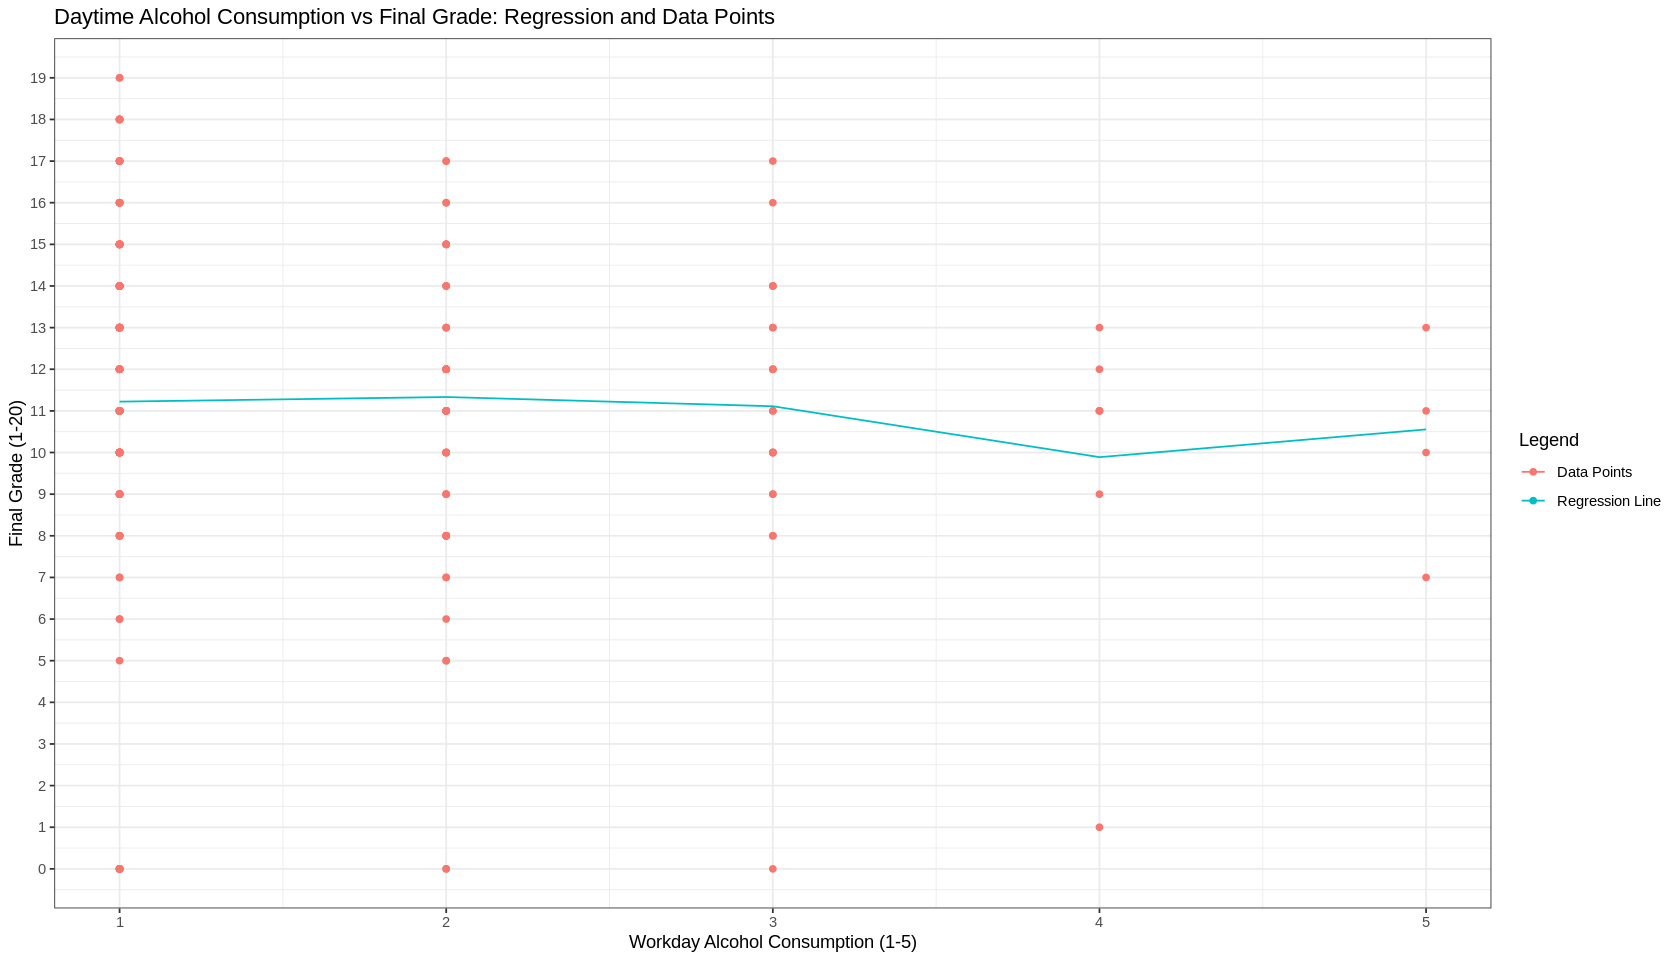

In [75]:
#Plot the KNN regression
plot_final <- predictions %>%  
    ggplot(aes(x = Dalc, 
               y = G3,
              color = "black")) + 
    geom_point() + 
    labs(x = "Workday Alcohol Consumption (1-5)", 
         y = "Final Grade (1-20)") + 
    geom_line(data = predictions, 
              aes(x = Dalc, 
                  y = .pred,
                 color = "blue")) +
    scale_color_discrete(name = "Legend", labels = c("Data Points",
                                                    "Regression Line")) +
    ggtitle("Daytime Alcohol Consumption vs Final Grade: Regression and Data Points") + 
    scale_y_continuous(n.breaks = 20) + 
    theme_bw()

plot_final

Figure 5. Plot displaying our regression line over the data points


# Discussion

In our exploratory data analysis, we found that alcohol consumption (both workday and weekday) was inversely proportional to high grades (>= 15), while the frequency of going out had a more complex relationship showing that a moderate amount of going out resulted in the highest number of students with good grades. 

From this data, we wished to see if these three predictive variables (2 inversely proportional and 1 somewhat proportional) could be used to predict letter grades. After performing K Nearest Neighbours Classification on our dataset, we found that going out, daytime alcohol consumption, and weekend alcohol consumption are poor predictors of student's final grades with an accuracy of ~13%. We believe that the low accuracy scores could be caused by the type of data in the dataset. Time spent going out (goout) Workday (Dalc) and weekend (Walc) alcohol consumption predictors are all discrete quantitative data. This means that the data could only take on certain values (in this case 1, 2, 3, 4, or 5). As K Nearest Neighbours Classification traditionally uses continuous data to predict the outcome variable, this could have contributed to the low accuracy score. 

Another reason for the low accuracy score could be how we are simplifying the data. By simplifying the problem and focusing on 3 predictive variables, we could be introducing a number of confounding variables. For example, we did not take into account student age (15-22 in this dataset) as underage drinking versus responsible social drinking could have very different effects. Other examples include studying time, travel time, home internet, parent's status (eductaion, divorce, single parent etc.) etc. 

Because our predictor has quite a low accuracy score, this classifier would not be useful to teachers as a method of predicting a students final grade. 

After discovering the low accuracy scores of the KNN Classification, we decided to attempt K Nearest Neighbours Regression to determine if it was a more effective prediction method. After performing the analysis, we again ran into issues with the data being discrete. As seen in KNN Regression plot, the data is not linear and data points only appear at specific points on the x-axis. Due to this, regression is not a suitable predictive model for our question for this dataset. 

Although we discovered a small correlation between alcohol consumption and final grades, we expected the accuracy score to be much higher. We also did not expect to run into problems dealing with discrete data types. The impacts of our findings could be beneficial for teachers to gain a general idea on how students will perform according to their alcohol consumption, but in general students may be unforthcoming with this information. Instead, if teachers were looking into predictors for student final grades, this study may allow teachers to rule out using a small number of predictors to predict student's academic performance.

Our poor accuracy and RMSPE results from using only select predictors shows how a multitude of factors can affect student's academic performance. It is also important to note that there may be significant cultural differences between North America (Canada) and Europe (Portugal) and alcohol consumption may be a widely accepted cultural social activity in Portugal while in Canada it may be less so. 
 
Some future questions our study could lead to include:
+ What other predictors give a more accurate prediction into student final grade scores?
+ What other machine learning models could take in a high number of predictors and not fall apart or be too slow? 
+ Is there a way to measure alcohol consumption on a more linear scale (i.e. by milliliters consumed)?


# Citations





1. P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. Retrieved from https://archive.ics.uci.edu/ml/datasets/Student+Performance.

2. Sung, D. J., So, W. Y., & Jeong, T. T. (2016). Association between alcohol consumption and academic achievement: a cross-sectional study. Central European journal of public health, 24(1), 45.

3. Flashman, J. (2012). Academic achievement and its impact on friend dynamics. Sociology of education, 85(1), 61-80.